## load_gcb_roeden2021-subsampling

#### with output fgco2, spco2, apco2


In [1]:
#after changes in the script using Jupyter notebook, save, and run this:
#get_ipython().system(u'jupyter nbconvert --to=python load_gcb_roeden2021-subsampling.ipynb')

In [2]:
# for subsampling experiment, data includes year 2019, hence final year is here set to 2020!!

import numpy as np ##double check loaded modules through file!
import math
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
#import interp_horizontal_boxcar as ihp 
from annualmean import annualmean


import sys
import os
sys.path.append('../')


### load pre-interpolated from temp_data_storage/*.npy
load_pre_interp = False

### input files: these have OCIM as prior and no Schmidt number correction!
#indir = '/work/ollie/jhauck/subsampling/roedenbeck/v2021/'
# fileA = 'oc_Syn_FESOM_v2021_daily.nc'
# fileA1 = 'oc_Syn_FESOM_v2021_pCO2_daily.nc'

# fileB = 'oc_Syn_FESOM_SOCCOM_v2021_daily.nc'
# fileB1 = 'oc_Syn_FESOM_SOCCOM_v2021_pCO2_daily.nc'

# fileC = 'oc_Syn_FESOM_ARGO6_v2021_daily.nc'
# fileC1 = 'oc_Syn_FESOM_ARGO6_v2021_pCO2_daily.nc'

# these have OCIM as prior and Schmidt number correction:

indir = '/work/ollie/jhauck/subsampling/roedenbeck/update_Nov2022_Schmidtnumber/'
fileA = 'oc_Syn_FESOM_v2021Sc_daily.nc'
fileA1 = 'oc_Syn_FESOM_v2021Sc_pCO2_daily.nc'

fileB = 'oc_Syn_FESOM_SOCCOM_v2021Sc_daily.nc'
fileB1 = 'oc_Syn_FESOM_SOCCOM_v2021Sc_pCO2_daily.nc'

fileC = 'oc_Syn_FESOM_ARGO6_v2021Sc_daily.nc'
fileC1 = 'oc_Syn_FESOM_ARGO6_v2021Sc_pCO2_daily.nc'

#fileC = 'oc_v2020_paCO2_daily.nc'

    
### gcb time
tsteps = (2021-1958)*12
gcb_time = np.arange(1958,2021-1./24,step=1./12)
timenew = np.append(gcb_time,2021.) #to get monthly mean of last month in dataset
print(np.shape(gcb_time))#,gcb_time)

#print(timenew)
gcb_years = np.arange(1958,2021,step=1)
nyears = 2021-1958
print(gcb_years,nyears)

xax = np.arange(0.5,360.5,1)
yax = np.arange(-89.5,90.5,1)
lat, lon = np.meshgrid(yax,xax, indexing='ij')

#print('tsteps',tsteps, np.shape(tsteps))
#print('timenew',timenew, np.shape(timenew))

[NbConvertApp] Converting notebook annualmean.ipynb to python
[NbConvertApp] Writing 2130 bytes to annualmean.py
(756,)
[1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971
 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985
 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020] 63


(756, 180, 360)


<ipython-input-3-98a9b23b969c>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(lon, lat,mask_roeden[1,:,:].conj())  # region index 1 for ocean


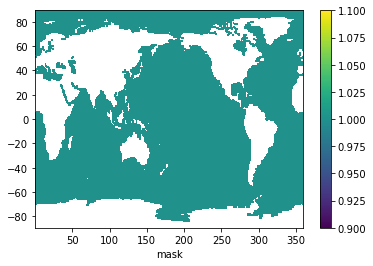

<ipython-input-3-98a9b23b969c>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(reg_lon, reg_lat,reg_arc)  # region index 1 for ocean


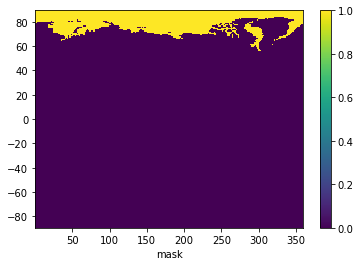

In [3]:
### load WOA surface mask    
try:    #### compare with statements in gcb_load
    inmask = Dataset('/work/ollie/jhauck/gcp2018/matlab/WOAsurfacemask.nc', mode='r')
    WOA_seamask = inmask.variables['MASKT'][:] #dadurch kein netcdf4 format mehr!
    WOA_seamask[WOA_seamask<=0] = np.nan
    WOA_seamaskB = np.ma.filled(WOA_seamask, fill_value=np.nan)
except:
    raise
    
mask_roeden = np.tile(WOA_seamaskB,(tsteps,1,1)) 
print(np.shape(mask_roeden))


if __name__=='__main__':
         plt.figure()
         plt.pcolor(lon, lat,mask_roeden[1,:,:].conj())  # region index 1 for ocean
         plt.colorbar()
         plt.xlabel('mask')
         plt.show()
              
            
            
# load reccap mask for Arctic
regions = Dataset('/work/ollie/jhauck/reccap/RECCAP2-shared-resources/data/regions/RECCAP2_region_masks_all.nc',mode='r')
reg_lon = regions['lon'][:]
reg_lat = regions['lat'][:]
reg_arc = regions['arctic'][:]
reg_arc[reg_arc>0]=1

if __name__=='__main__':
         plt.figure()
         plt.pcolor(reg_lon, reg_lat,reg_arc)  # region index 1 for ocean
         plt.colorbar()
         plt.xlabel('mask')
         plt.show()
              

In [4]:
#-----------------------------------------------------
# make a routine for loading Rödenbeck CO2 flux data 
# that can be called to avoid errors/inconsistencies 
# in unit conversion and such
# this is so far for gridded co2flux and globally and regionally integrated CO2 flux
# NOT YET for pCO2
#-----------------------------------------------------

def load_roeden(dirIN,fileIN):
        
    # load data
    in_data = Dataset(dirIN+fileIN, mode='r')
    fgco2 = in_data['co2flux_ocean'][:]  # 		ocCO2:units = "Tmol/yr" ;
    area = in_data['dxyp'][:]  # 		ocCO2:units = "Tmol/yr" ;
    roeden_lon = in_data['lon'][:]
    roeden_lat = in_data['lat'][:]
    year = in_data['myear'][:]
    
    print(year)
    print(np.shape(fgco2))
    print(np.min(lon),np.max(lon))

    # prepare grid:
    roeden_lonD = []
    roeden_lonD[0:72] = roeden_lon[72:]
    roeden_lonD[72:] = roeden_lon[:72] +360

    roeden_lati,roeden_lonDi = np.meshgrid(roeden_lat,roeden_lonD, indexing='ij')
    
    #first apply area mask
#    fgco2 = in_data['co2flux_ocean'][:]
    nt = fgco2.shape[0] #number of timesteps

    areat = np.tile(np.squeeze(in_data['dxyp'][:,:]),(nt,1,1)) #area[rt=1,:,:] area for ocean only
    fgco2[areat == 0.] = np.nan
    fgco2 = np.ma.filled(fgco2, fill_value= np.nan)
    #print np.nanmin(fgco2), np.nanmax(fgco2), type(fgco2), np.shape(fgco2)

    if __name__=='__main__':
         plt.figure()
         plt.pcolor( roeden_lon, roeden_lat,areat[-1,:,:].conj())
         plt.colorbar()
         plt.xlabel('area')
         plt.show()

    areat_div = np.copy(areat)
    areat_div[areat_div == 0.] = np.nan #to prevent division by zero
    
    #------------------------------------
    # unit conversion now here:
    
    ## convert to right units (mol/m2/s)
   
    # PgC/yr ---> does not seem to be this unit, double check
    # divide by area to have Pg/m2/yr
    
    # *1e15 : Pg --> g
    # /12   : g --> mol
    # /365/86400 to get from per year to per second
    # change flux direction *-1
    conv= 1e15/12/365.25/86400
    fgco2C= -(fgco2*conv)/areat_div
    #print np.nanmin(fgco2C), np.nanmax(fgco2C) 

    
    
    
    ## then transform longitude to 0 : 360

    fgco2D = np.empty_like(fgco2C)
    fgco2D[:,:,0:72] = fgco2C[:,:,72:] 
    fgco2D[:,:,72:] = fgco2C[:,:,:72]
    print(np.shape(fgco2D))
    #print np.nanmin(fgco2D), np.nanmax(fgco2D) 

    if __name__=='__main__':

        plt.figure()
        plt.pcolor(fgco2D[-1,:,:])#*365.25*86400,vmin=4, vmax=4)
        plt.colorbar()
        plt.xlabel('input fgco2')#, now converted to mol/m2/yr')
        plt.show()


    ## calculate monthly means
  #  myear = in_data['myear'][:]
    fgco2_monthly = np.nan * np.zeros((tsteps, 90,144)) #(time, latitude, longitude)
    
    print('shape(fgco2_monthly)',np.shape(fgco2_monthly))

    for it in range(0,len(timenew)-1):
        a1 = year >= timenew[it] #start of month
        a2 = year < timenew[it+1] #end of month
        ind_time = np.where(a1*a2)
#        print(np.shape(fgco2_monthly[it,:,:]), np.shape(np.nanmean(np.squeeze(fgco2D[ind_time,:,:]),axis=0)))
#        print(it,ind_time)
        fgco2_monthly[it,:,:] = np.nanmean(fgco2D[ind_time][:][:],axis=0)



    if __name__=='__main__':

        plt.figure()
        plt.pcolor(fgco2_monthly[-1,:,:])#*365.25*86400,vmin=4, vmax=4)
        plt.colorbar()
        plt.xlabel('roeden fgco2 monthly mean, now converted to mol/m2/yr')
        plt.show()

    ### starting interpolation
    
    #adjusting points and values for interpolation
    #print('\nfgco2\nInput shapes: {}\n{} {}'.format(np.shape(fgco2_monthly), np.shape(roeden_lati), np.shape(roeden_lonDi)))

    ### interpolate to 1x1 degree grid
    # add 'A' to name for consistency with model nomenclature
    roeden_fgco2_1x1 = np.nan * np.zeros((tsteps,len(yax),len(xax))) #(time, latitude, longitude)
 
    for iip in range(tsteps):
        frac_now = math.ceil(float(iip)/tsteps*10)
        frac_next = math.ceil(float(iip+1)/tsteps*10)
        if (frac_next > frac_now):
            print('interpolating {} % is done'.format(frac_now*10))

        # in one step
        roeden_fgco2_1x1[iip,:,:] = griddata((roeden_lati.ravel(),roeden_lonDi.ravel()), fgco2_monthly[iip,:,:].ravel(), (lat,lon), method='nearest')


    print('Interpolating fgco2 finished\n')  
    #print('Output shape of {} is {}\n with min = {} and max = {}'.format('roeden_fgco2_1x1',np.shape(roeden_fgco2_1x1),np.nanmin(roeden_fgco2_1x1), np.nanmax(ro
#eden_fgco2_1x1)))



    ### implement WOA mask to interpolated data
    roeden_fgco2_1x1[mask_roeden != 1] = np.nan 
    roeden_fgco2_1x1 = np.ma.filled(roeden_fgco2_1x1, fill_value=np.nan) 
    
    
    #-----------------------------------------------------------------
    ## the above was for gridded fields, now comes time-series directly from native mesh:
    
    # as this comes already as areal sum, sum up into global and regional integrals directly:

    # first annual mean, then make mask:
    
    print('now summing up on native mesh ...')
    
    # convert to annual:
    fgco2_annual = np.nan * np.zeros((nyears, 90,144)) #(time, latitude, longitude)

    for it in range(0,nyears-1):
        a1 = year >= gcb_years[it] #start of year
        a2 = year < gcb_years[it+1] #end of year
        ind_time = np.where(a1*a2)
        #print np.shape(fgco2_monthly[it,:,:]), np.shape(np.nanmean(np.squeeze(fgco2D[ind_time,:,:]),axis=0))
        fgco2_annual[it,:,:] = np.nanmean(fgco2[ind_time][:][:],axis=0)

    print(np.shape(fgco2_annual))    
    
    # first make reg_arctic same time dimension:
#    reg_arcT = np.tile(reg_arc,(nyears,1,1)) #area[rt=1,:,:] area for ocean only


    fgco2_global =-np.nansum(np.nansum(fgco2_annual[:,:,:],axis=2),axis=1)
    print(fgco2_global)
    print(np.shape(fgco2_global))

    fgco2_N =-np.nansum(np.nansum(fgco2_annual[:,roeden_lat>30,:],axis=2),axis=1)
    print(fgco2_N)
    print(np.shape(fgco2_N))
    
    fgco2_Arc =-np.nansum(np.nansum(fgco2_annual[:,roeden_lat>60,:],axis=2),axis=1)
    print(fgco2_Arc)
    print(np.shape(fgco2_Arc))
    
    fgco2_N60 =-np.nansum(np.nansum(fgco2_annual[:,(roeden_lat>30) & (roeden_lat<=60),:],axis=2),axis=1)
    print(fgco2_N60)
    print(np.shape(fgco2_N60))

    fgco2_T =-np.nansum(np.nansum(fgco2_annual[:,(roeden_lat>-30) & (roeden_lat<30),:],axis=2),axis=1)
    print(fgco2_T)
    print(np.shape(fgco2_T))

    fgco2_S =-np.nansum(np.nansum(fgco2_annual[:,roeden_lat<-30,:],axis=2),axis=1)
    print(fgco2_S)
    print(np.shape(fgco2_S))

    return roeden_fgco2_1x1, fgco2_global, fgco2_N, fgco2_Arc, fgco2_N60, fgco2_T, fgco2_S
    
    

In [5]:
#routine for loaading pCO2 data:

def load_roeden_pCO2(dirIN,fileIN):

####loading data for spco2

    in_data = Dataset(dirIN+fileIN, mode='r')
    print('\n loading spco2')

    spco2 = np.array(in_data['pCO2'] )
    roeden_lon = in_data['lon'][:]
    roeden_lat = in_data['lat'][:]
    myear = in_data['myear'][:]
    area = in_data['dxyp'][:]  # 		ocCO2:units = "Tmol/yr" ;

    # prepare grid for interpolation:
    roeden_lonD = []
    roeden_lonD[0:72] = roeden_lon[72:]
    roeden_lonD[72:] = roeden_lon[:72] +360

    roeden_lati,roeden_lonDi = np.meshgrid(roeden_lat,roeden_lonD, indexing='ij')
    
    # area:
    nt = spco2.shape[0] #number of timesteps
    
    print(np.shape(spco2),nt,np.shape(area))
    areat = np.tile(area,(nt,1,1)) #area[rt=1,:,:] area for ocean only
    
    spco2[areat == 0.] = np.nan
    spco2[spco2<0] = np.nan

    # from -180 to 180 to 0-360
    spco2D = np.zeros(np.shape(spco2))
    spco2D[:,:,0:72] = spco2[:,:,72:]
    spco2D[:,:,72:] = spco2[:,:,0:72]
    
    
    

    #print np.shape(spco2), np.shape(areat)
    #print np.nanmin(spco2), np.nanmax(spco2) 

    if __name__=='__main__':

        plt.figure()
        #plt.subplot(2,2,3)
        plt.pcolor(spco2D[-1,:,:], vmin=-70, vmax=750)
        plt.colorbar()
        plt.xlabel('input spco2')
        plt.show()

    #calculate monthly means
    spco2_monthly = np.nan * np.zeros((tsteps, 90,144))

    for it in range(0,len(timenew)-1):
     a1 = myear >= timenew[it] #start of month
     a2 = myear < timenew[it+1] #end of month
     ind_time = np.where(a1*a2)
     spco2_monthly[it,:,:] = np.nanmean(spco2D[ind_time][:][:],axis=0)

    #print('monthly min {} max {}'.format(np.nanmin(spco2_monthly), np.nanmax(spco2_monthly)))

    if __name__=='__main__':

        plt.figure()
        #plt.subplot(2,2,3)
        plt.pcolor(np.squeeze(spco2_monthly[-1,:,:]), vmin=-60, vmax=750)
        plt.colorbar()
        plt.xlabel('spco2 monthly means')
        plt.show()

    #### adjusting points and values for interpolation
    #print('Input shapes: {}\n{} {}'.format(np.shape(spco2_monthly), np.shape(roeden_lati), np.shape(roeden_lonDi)))

    ### interpolate to 1x1 degree grid
    roeden_spco2_1x1 = np.nan * np.zeros((tsteps,len(yax),len(xax))) #(time, latitude, longitude)

    #print('Output shapes:{}\n{} {}\n'.format(np.shape(roeden_spco2_1x1), np.shape(lat), np.shape(lon)))

    for iip in range(tsteps):
        frac_now = math.ceil(float(iip)/tsteps*10)
        frac_next = math.ceil(float(iip+1)/tsteps*10)
        if (frac_next > frac_now):
           print('interpolating {} % is done'.format(frac_now*10))

        # first interpolate to 2D field without nans
        #ind = ~np.isnan(spco2_monthly[iip,:,:]) # The index of aux that are not NaNs
        #aux = griddata((roeden_lati[ind],roeden_lonDi[ind]), spco2_monthly[iip,:,:][ind], (roeden_lati,roeden_lonDi),method='nearest')

        # second interpolate to new grid
        #roeden_spco2_1x1[iip,:,:] = griddata((roeden_lati.ravel(),roeden_lonDi.ravel()), aux.ravel(), (lat,lon), method='nearest')

        roeden_spco2_1x1[iip,:,:] = griddata((roeden_lati.ravel(),roeden_lonDi.ravel()), spco2_monthly[iip,:,:].ravel(), (lat,lon), method='nearest')

    print('\nInterpolating spco2 finished')  

    ### implement WOA mask to interpolated data
    roeden_spco2_1x1[mask_roeden != 1] = np.nan
    roeden_spco2_1x1 = np.ma.filled(roeden_spco2_1x1, fill_value=np.nan) 

    #print('Output shape of {} is {}\n with min = {} and max = {}'.format('roeden_spco2_1x1',np.shape(roeden_spco2_1x1),np.nanmin(roeden_spco2_1x1), np.nanmax(roeden_spco2_1x1))
#)
    print('min {} max {}'.format(np.nanmin(roeden_spco2_1x1), np.nanmax(roeden_spco2_1x1)))
    print(np.shape(roeden_spco2_1x1))
    
    #------------------------------------------
    # average into regions from native mesh:
    #------------------------------------------

    area_glo = np.nansum(area)
    area_N   = np.nansum(area[roeden_lat>30])
    area_Arc = np.nansum(area[roeden_lat>60])
    area_N60   = np.nansum(area[(roeden_lat>30) & (roeden_lat<=60)])
    area_T   = np.nansum(area[(roeden_lat>-30) & (roeden_lat<30)])
    area_S   = np.nansum(area[roeden_lat<-30])

    print('total area in glo, N, Arc, N60, T, S: ',area_glo,area_N,area_Arc,area_N60,area_T,area_S)

    # area-weighting (times 3d area, divide by total regional area), afterwards averaging (NaNs where no data)
    spco2_glo = np.nansum(np.nansum((spco2 *areat),2),1)/area_glo
    
    print(spco2_glo)
    print(np.shape(spco2_glo))

    spco2_N = np.nansum(np.nansum(spco2[:,roeden_lat>30,:] *areat[:,roeden_lat>30,:],2),1)/area_N
    spco2_Arc = np.nansum(np.nansum(spco2[:,roeden_lat>60,:] *areat[:,roeden_lat>60,:],2),1)/area_Arc
    spco2_N60 = np.nansum(np.nansum(spco2[:,(roeden_lat>30) & (roeden_lat<=60),:] *areat[:,(roeden_lat>30) & (roeden_lat<=60),:],2),1)/area_N60
    spco2_T = np.nansum(np.nansum(spco2[:,(roeden_lat>-30) & (roeden_lat<30),:] *areat[:,(roeden_lat>-30) & (roeden_lat<30),:],2),1)/area_T
    spco2_S = np.nansum(np.nansum(spco2[:,roeden_lat<-30,:] *areat[:,roeden_lat<-30,:],2),1)/area_S
   
    
    

    return roeden_spco2_1x1, spco2_glo, spco2_N, spco2_Arc, spco2_N60, spco2_T, spco2_S


[1958.00136986 1958.00410959 1958.00684932 ... 2020.9931694  2020.99590164
 2020.99863388]
(23011, 90, 144)
0.5 359.5


<ipython-input-4-67e43bdb7fb7>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor( roeden_lon, roeden_lat,areat[-1,:,:].conj())


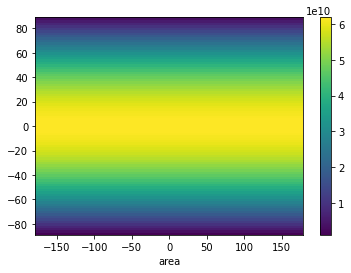

(23011, 90, 144)


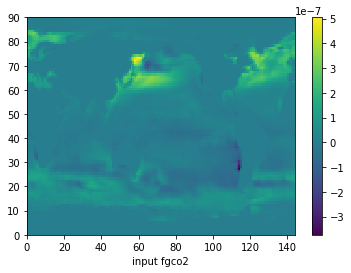

shape(fgco2_monthly) (756, 90, 144)


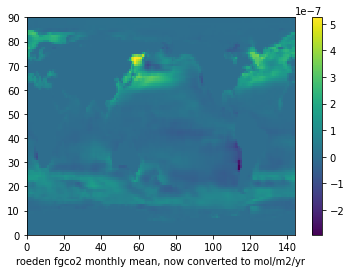

interpolating 0 % is done
interpolating 10 % is done
interpolating 20 % is done
interpolating 30 % is done
interpolating 40 % is done
interpolating 50 % is done
interpolating 60 % is done
interpolating 70 % is done
interpolating 80 % is done
interpolating 90 % is done
Interpolating fgco2 finished

now summing up on native mesh ...
(63, 90, 144)
[ 0.14588091  0.52922594  0.56766628  0.57155968  0.52395983  0.53133865
  0.72059725  0.63504348  0.68485158  0.68694417  0.67799124  0.71084889
  0.88698246  0.6868083   0.6524132   0.80447744  0.76428973  0.72347198
  0.7642499   0.92286642  1.08383959  1.09897906  1.42449636  1.4653415
  1.46495014  1.66561285  1.70908915  1.6029209   1.69473364  1.85844319
  1.98918231  1.85611335  1.78879128  1.90537906  2.18268499  2.20733966
  2.19400476  2.18761238  2.19554658  2.12092606  2.47376159  2.23976255
  2.07498736  1.94532591  2.3721485   2.52698607  2.35929756  2.55460686
  2.65309877  2.77212981  2.46986408  2.52357349  2.77566644  2.804197

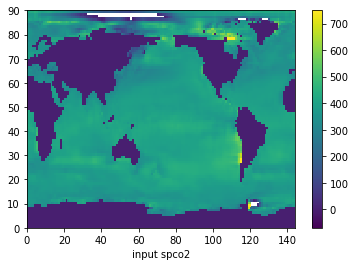

<ipython-input-5-5ff2875d7642>:59: RuntimeWarning: Mean of empty slice
  spco2_monthly[it,:,:] = np.nanmean(spco2D[ind_time][:][:],axis=0)


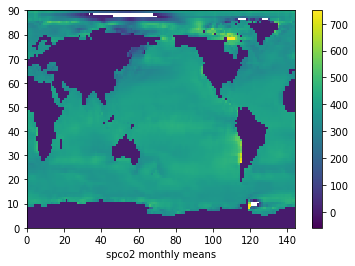

interpolating 0 % is done
interpolating 10 % is done
interpolating 20 % is done
interpolating 30 % is done
interpolating 40 % is done
interpolating 50 % is done
interpolating 60 % is done
interpolating 70 % is done
interpolating 80 % is done
interpolating 90 % is done

Interpolating spco2 finished
min 0.0 max 2142.3657777847784
(756, 180, 360)
total area in glo, N, Arc, N60, T, S:  510705130000000.0 127676275000000.0 34210760000000.0 93465520000000.0 255352550000000.0 127676290000000.0
[239.05633544921875 239.20794677734375 239.3601837158203 ...
 297.6699523925781 297.70489501953125 297.7425231933594]
(23011,)


In [6]:
# load SOCAT only

#co2 flux
[roeden_fgco2_1x1_A,roeden_fgco2_PgCyr_A_glo,roeden_fgco2_PgCyr_A_N,roeden_fgco2_PgCyr_A_Arc,
 roeden_fgco2_PgCyr_A_N60,roeden_fgco2_PgCyr_A_T,roeden_fgco2_PgCyr_A_S] = load_roeden(indir,fileA)

# add Sc to filename to distinguish when Schmidt number was applied:
np.save('roedenSc_fgco2_1x1_A_subsampling.npy',roeden_fgco2_1x1_A.data)
np.save('roedenSc_fgco2_PgCyr_A_glo.npy',roeden_fgco2_PgCyr_A_glo.data)
np.save('roedenSc_fgco2_PgCyr_A_N.npy',roeden_fgco2_PgCyr_A_N.data)
np.save('roedenSc_fgco2_PgCyr_A_Arc.npy',roeden_fgco2_PgCyr_A_Arc.data)
np.save('roedenSc_fgco2_PgCyr_A_N60.npy',roeden_fgco2_PgCyr_A_N60.data)
np.save('roedenSc_fgco2_PgCyr_A_T.npy',roeden_fgco2_PgCyr_A_T.data)
np.save('roedenSc_fgco2_PgCyr_A_S.npy',roeden_fgco2_PgCyr_A_S.data)

# pco2
[roeden_spco2_1x1_A,roeden_spco2_A_glo,roeden_spco2_A_N,roeden_spco2_A_Arc,
 roeden_spco2_A_N60,roeden_spco2_A_T,roeden_spco2_A_S] = load_roeden_pCO2(indir,fileA1)

np.save('roedenSc_spco2_1x1_A_subsampling.npy',roeden_spco2_1x1_A.data)
np.save('roedenSc_spco2_A_glo.npy',roeden_spco2_A_glo.data)
np.save('roedenSc_spco2_A_N.npy',roeden_spco2_A_N.data)
np.save('roedenSc_spco2_A_Arc.npy',roeden_spco2_A_Arc.data)
np.save('roedenSc_spco2_A_N60.npy',roeden_spco2_A_N60.data)
np.save('roedenSc_spco2_A_T.npy',roeden_spco2_A_T.data)
np.save('roedenSc_spco2_A_S.npy',roeden_spco2_A_S.data)


In [7]:
print(roeden_spco2_A_glo)

[239.05633544921875 239.20794677734375 239.3601837158203 ...
 297.6699523925781 297.70489501953125 297.7425231933594]


[1958.00136986 1958.00410959 1958.00684932 ... 2020.9931694  2020.99590164
 2020.99863388]
(23011, 90, 144)
0.5 359.5


<ipython-input-4-67e43bdb7fb7>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor( roeden_lon, roeden_lat,areat[-1,:,:].conj())


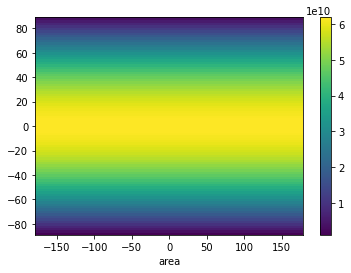

(23011, 90, 144)


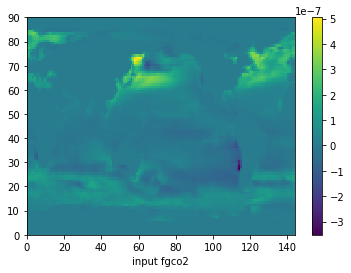

shape(fgco2_monthly) (756, 90, 144)


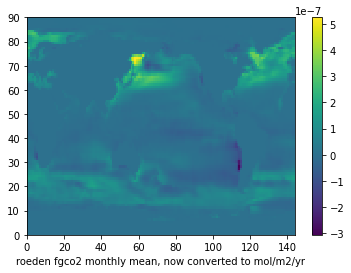

interpolating 0 % is done
interpolating 10 % is done
interpolating 20 % is done
interpolating 30 % is done
interpolating 40 % is done
interpolating 50 % is done
interpolating 60 % is done
interpolating 70 % is done
interpolating 80 % is done
interpolating 90 % is done
Interpolating fgco2 finished

now summing up on native mesh ...
(63, 90, 144)
[ 0.15549012  0.51015875  0.53814883  0.54337272  0.49499516  0.49600505
  0.68695337  0.60823653  0.6435196   0.64539943  0.6396986   0.67459172
  0.85372525  0.66276543  0.62110036  0.76771609  0.7378129   0.70262748
  0.74325258  0.90335211  1.05982746  1.05881888  1.38525222  1.43394275
  1.43755287  1.62028124  1.67383031  1.56628934  1.65248726  1.82123236
  1.94228339  1.80432966  1.74414159  1.86168679  2.13687697  2.16332637
  2.16499245  2.15098864  2.14599786  2.08126696  2.43023518  2.19763745
  2.0405199   1.88939353  2.32031232  2.4795465   2.32502128  2.52775493
  2.63272648  2.72330272  2.42279797  2.47610206  2.71645629  2.75144

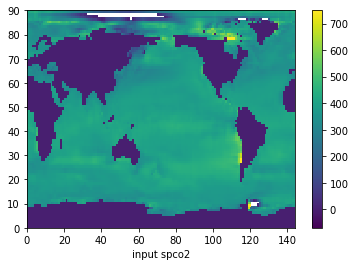

<ipython-input-5-5ff2875d7642>:59: RuntimeWarning: Mean of empty slice
  spco2_monthly[it,:,:] = np.nanmean(spco2D[ind_time][:][:],axis=0)


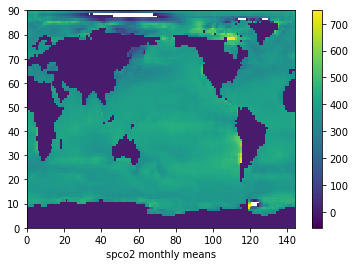

interpolating 0 % is done
interpolating 10 % is done
interpolating 20 % is done
interpolating 30 % is done
interpolating 40 % is done
interpolating 50 % is done
interpolating 60 % is done
interpolating 70 % is done
interpolating 80 % is done
interpolating 90 % is done

Interpolating spco2 finished
min 0.0 max 2142.951431766633
(756, 180, 360)
total area in glo, N, Arc, N60, T, S:  510705130000000.0 127676275000000.0 34210760000000.0 93465520000000.0 255352550000000.0 127676290000000.0
[238.72799682617188 238.86314392089844 238.99917602539062 ...
 297.6479187011719 297.6684875488281 297.6919860839844]
(23011,)


In [8]:
# socat+soccom

# co2 flux:
[roeden_fgco2_1x1_B,roeden_fgco2_PgCyr_B_glo,roeden_fgco2_PgCyr_B_N,
 roeden_fgco2_PgCyr_B_Arc,roeden_fgco2_PgCyr_B_N60,roeden_fgco2_PgCyr_B_T,
 roeden_fgco2_PgCyr_B_S] = load_roeden(indir,fileB)

# add Sc to filename to distinguish when Schmidt number was applied:
np.save('roedenSc_fgco2_1x1_B_subsampling.npy',roeden_fgco2_1x1_B.data)
np.save('roedenSc_fgco2_PgCyr_B_glo.npy',roeden_fgco2_PgCyr_B_glo.data)
np.save('roedenSc_fgco2_PgCyr_B_N.npy',roeden_fgco2_PgCyr_B_N.data)
np.save('roedenSc_fgco2_PgCyr_B_Arc.npy',roeden_fgco2_PgCyr_B_Arc.data)
np.save('roedenSc_fgco2_PgCyr_B_N60.npy',roeden_fgco2_PgCyr_B_N60.data)
np.save('roedenSc_fgco2_PgCyr_B_T.npy',roeden_fgco2_PgCyr_B_T.data)
np.save('roedenSc_fgco2_PgCyr_B_S.npy',roeden_fgco2_PgCyr_B_S.data)

# pco2
[roeden_spco2_1x1_B,roeden_spco2_B_glo,roeden_spco2_B_N,roeden_spco2_B_Arc,
 roeden_spco2_B_N60,roeden_spco2_B_T,roeden_spco2_B_S] = load_roeden_pCO2(indir,fileB1)

np.save('roedenSc_spco2_1x1_B_subsampling.npy',roeden_spco2_1x1_B.data)
np.save('roedenSc_spco2_B_glo.npy',roeden_spco2_B_glo.data)
np.save('roedenSc_spco2_B_N.npy',roeden_spco2_B_N.data)
np.save('roedenSc_spco2_B_Arc.npy',roeden_spco2_B_Arc.data)
np.save('roedenSc_spco2_B_N60.npy',roeden_spco2_B_N60.data)
np.save('roedenSc_spco2_B_T.npy',roeden_spco2_B_T.data)
np.save('roedenSc_spco2_B_S.npy',roeden_spco2_B_S.data)

[1958.00136986 1958.00410959 1958.00684932 ... 2020.9931694  2020.99590164
 2020.99863388]
(23011, 90, 144)
0.5 359.5


<ipython-input-4-67e43bdb7fb7>:41: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor( roeden_lon, roeden_lat,areat[-1,:,:].conj())


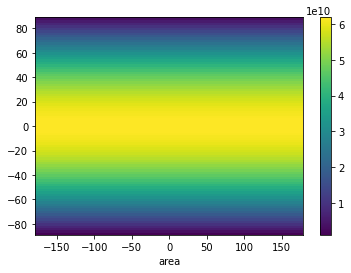

(23011, 90, 144)


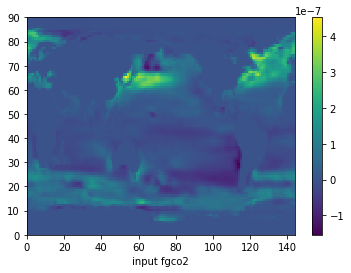

shape(fgco2_monthly) (756, 90, 144)


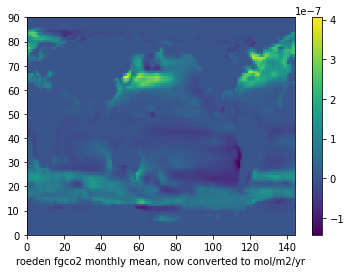

interpolating 0 % is done
interpolating 10 % is done
interpolating 20 % is done
interpolating 30 % is done
interpolating 40 % is done
interpolating 50 % is done
interpolating 60 % is done
interpolating 70 % is done
interpolating 80 % is done
interpolating 90 % is done
Interpolating fgco2 finished

now summing up on native mesh ...
(63, 90, 144)
[ 0.91776331  1.13907218  1.19649626  1.0773872   1.0555838   1.14340145
  1.43838371  1.37407013  1.37373833  1.24755086  1.16642188  1.177817
  1.26803996  1.17195588  1.24186208  1.36004739  1.33141169  1.2068354
  1.23205681  1.40919042  1.52937291  1.27085352  1.74607088  1.82707784
  1.86458958  1.99340057  2.0178737   1.7519083   1.77216447  1.77493138
  1.99511177  1.73269859  1.75167914  1.88498912  2.15791672  2.16206171
  2.06269072  2.14804176  2.13181596  1.93343119  2.27116833  2.10410703
  1.93917754  1.72769958  2.15039722  2.23739412  2.12111781  2.23159708
  2.31386525  2.50433304  2.23542465  2.14163885  2.23512142  2.48369542

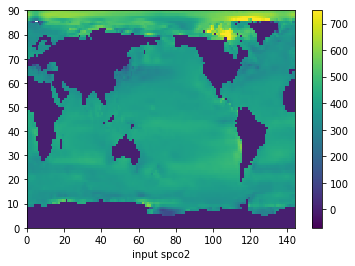

<ipython-input-5-5ff2875d7642>:59: RuntimeWarning: Mean of empty slice
  spco2_monthly[it,:,:] = np.nanmean(spco2D[ind_time][:][:],axis=0)


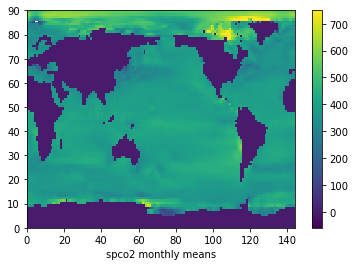

interpolating 0 % is done
interpolating 10 % is done
interpolating 20 % is done
interpolating 30 % is done
interpolating 40 % is done
interpolating 50 % is done
interpolating 60 % is done
interpolating 70 % is done
interpolating 80 % is done
interpolating 90 % is done

Interpolating spco2 finished
min 0.0 max 2755.1072486139115
(756, 180, 360)
total area in glo, N, Arc, N60, T, S:  510705130000000.0 127676275000000.0 34210760000000.0 93465520000000.0 255352550000000.0 127676290000000.0
[239.7200927734375 239.8313446044922 239.94398498535156 ...
 302.4090270996094 302.4517822265625 302.496826171875]
(23011,)


In [9]:
# full Argo coverage:

# co2 flux:

[roeden_fgco2_1x1_C,roeden_fgco2_PgCyr_C_glo,roeden_fgco2_PgCyr_C_N,
 roeden_fgco2_PgCyr_C_Arc,roeden_fgco2_PgCyr_C_N60,roeden_fgco2_PgCyr_C_T,
 roeden_fgco2_PgCyr_C_S] = load_roeden(indir,fileC)

# add Sc to filename to distinguish when Schmidt number was applied:
np.save('roedenSc_fgco2_1x1_C_subsampling.npy',roeden_fgco2_1x1_C.data)
np.save('roedenSc_fgco2_PgCyr_C_glo.npy',roeden_fgco2_PgCyr_C_glo.data)
np.save('roedenSc_fgco2_PgCyr_C_N.npy',roeden_fgco2_PgCyr_C_N.data)
np.save('roedenSc_fgco2_PgCyr_C_Arc.npy',roeden_fgco2_PgCyr_C_Arc.data)
np.save('roedenSc_fgco2_PgCyr_C_N60.npy',roeden_fgco2_PgCyr_C_N60.data)
np.save('roedenSc_fgco2_PgCyr_C_T.npy',roeden_fgco2_PgCyr_C_T.data)
np.save('roedenSc_fgco2_PgCyr_C_S.npy',roeden_fgco2_PgCyr_C_S.data)


# pco2 :
[roeden_spco2_1x1_C,roeden_spco2_C_glo,roeden_spco2_C_N,roeden_spco2_C_Arc,
 roeden_spco2_C_N60,roeden_spco2_C_T,roeden_spco2_C_S] = load_roeden_pCO2(indir,fileC1)

np.save('roedenSc_spco2_1x1_C_subsampling.npy',roeden_spco2_1x1_C.data)
np.save('roedenSc_spco2_C_glo.npy',roeden_spco2_C_glo.data)
np.save('roedenSc_spco2_C_N.npy',roeden_spco2_C_N.data)
np.save('roedenSc_spco2_C_Arc.npy',roeden_spco2_C_Arc.data)
np.save('roedenSc_spco2_C_N60.npy',roeden_spco2_C_N60.data)
np.save('roedenSc_spco2_C_T.npy',roeden_spco2_C_T.data)
np.save('roedenSc_spco2_C_S.npy',roeden_spco2_C_S.data)